In [6]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
from data_storage import create_connection
from stockstats import StockDataFrame
from risk_metrics import Risk_Metrics
import matplotlib.pyplot as plt
import os

In [7]:
connection = create_connection("../database/crypto_billionairs.db")

In [11]:
table = "BTC__random_forest_equity_curve"
research_table = "BTC_1min_complete_1day_preprocessed_1day_features_equity_curve"

In [12]:
df = pd.read_sql_query(f"select * from {table}", connection)
df2 = pd.read_sql_query(f"select * from {research_table}", connection)

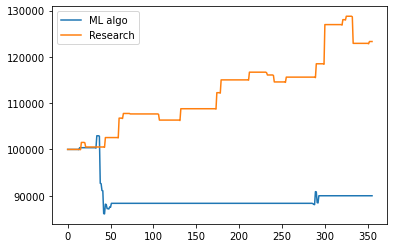

In [13]:
plt.plot(df["Equity"], label="ML algo")
plt.plot(df2["Equity"], label= "Research")
plt.legend()
plt.show()